In [26]:
import matplotlib.pyplot as plt
import numpy as np
import csv as csv

# from scipy.stats import norm
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.special import j1

In [27]:
# initialize everything

raw_xdata = []
raw_ydata = []
with open('fraunhofer.csv', mode='r') as f:
    read = csv.reader(f)
    next(read)
    for row in f:
        pair = row.split(',')
        raw_xdata.append(float(pair[0]))
        raw_ydata.append(float(pair[1][:-1]))

xdata = []
ydata = []

for i in range(28):
    xdata += [[x for x in raw_xdata[i::28]]]
    ydata += [[y for y in raw_ydata[i::28]]]

# # removing trial 4
# for i in range(28):
#     xdata[i] = xdata[i][:3]
#     ydata[i] = ydata[i][:3]

# # normalizing the y-data based on max reading
# for trial in range(4):
#     trial_max = max([ydata[i][trial] for i in range(28)])
#     for i in range(28):
#         ydata[i][trial] /= trial_max


# removing data from the fringes
a=2
xdata = xdata[a-1:-a]
ydata = ydata[a-1:-a]

xdata.pop(2)
ydata.pop(2)

xdata.pop(-3)
ydata.pop(-3)

xdata.pop(0)
ydata.pop(0)

yerr = np.std(ydata, axis=1)

# yerr[12] = 1e-5   # would be 0 otherwise (only use after normalizing y-data)

x_means = np.mean(xdata, axis=1)
y_means = np.mean(ydata, axis=1)
y_sems = yerr / np.sqrt(len(xdata[0]))

# print(ydata)

print(x_means)
print(y_means)
print(y_sems)



# print(ydata[22][1])

[ 2.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 24. 25.]
[ 1.675e-02 -1.000e-03  1.225e-01  4.350e-01  9.775e-01  1.750e+00
  2.725e+00  3.775e+00  4.725e+00  5.375e+00  5.650e+00  5.450e+00
  4.850e+00  3.925e+00  2.900e+00  1.875e+00  1.075e+00  5.425e-01
  1.375e-01 -1.950e-02  3.925e-02  5.375e-02]
[0.00216145 0.00357071 0.01138804 0.02561738 0.04067785 0.0559017
 0.073951   0.08926786 0.09601432 0.08196798 0.08291562 0.075
 0.075      0.08196798 0.06123724 0.04145781 0.04145781 0.07552938
 0.01138804 0.01755171 0.02086676 0.00235518]


### Fraunhofer Diffraction

We'd expect the intensity in our diffraction pattern to be described by the function
$$ I(\theta) = 4I_\textrm{max} \frac{[J_1(ka \sin \theta)]^2}{(ka \sin \theta)^2}. $$
Here are the fit considerations:

* We're not measuring intensity as a function of angle, we're measuring voltage as a function of position. So we'll be reporting a $V(x)$ in the data.
* We use the independent variable $x$ as a proxy for $a \sin \theta$, but the pattern's $\theta = 0$ isn't necessarily our $x = 0$. So we introduce the fit parameter $x_0$ as a constant offset.
* We'll introduce a constant of proportionality $A$ to take care of the coefficient in the theory.
* Our voltmeter has a constant offset, meaning $V = 0$ doesn't correspond to $I(\theta) = 0$. So we introduce a constant offset $V_0$.

In sum, we're fitting to the function
$$ V(x) = V_0 + A \frac{[J_1(k \cdot \frac{a}{r} (x - x_0))]^2}{(k \cdot \frac{a}{r} (x - x_0))^2}, $$
where $a$ is the radius of the diffraction aperture and $r$ is the aperture-detector distance.

[1, 13.1, -0.02, 0.5]
[22.42103517 13.04494473 -0.02763708  0.39707529]


<ErrorbarContainer object of 3 artists>

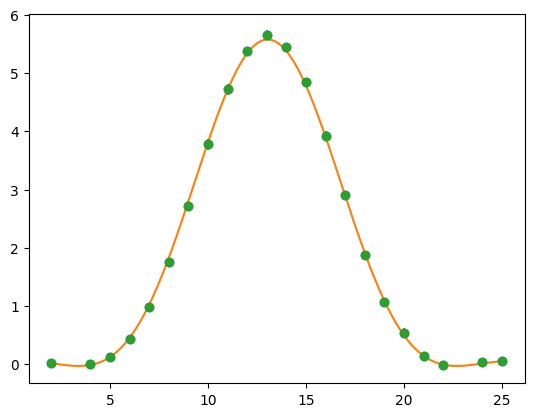

In [33]:
# perform the fit...

# k = 2*np.pi / (632.8e-6)   # 632.8 nm, expressed in mm
# diff_ap_radius = 50e-3  # 50 um, expressed in mm
# ap_ap_dist = 129e1   # 129 cm, expressed in mm
# a_r = diff_ap_radius / ap_ap_dist

# A = 25
def myfit(x, A, x0, V0, k):
    output = np.empty_like(x)
    is_small = np.isclose(x, x0)
    output[is_small] = V0 + A * 0.25
    output[~is_small] = V0 + A * ( j1(k*(x[~is_small]-x0)) / (k*(x[~is_small]-x0)) )**2
    return output

# def my_fit

# A = 22
# x0 = 13.1
# V0 = -0.02
# k = 0.5

# p0 = [22, 13.1, -0.02, 0.5]
p0 = [1, 13.1, -0.02, 0.5]
(popt, pcov) = curve_fit(myfit, x_means, y_means, sigma=y_sems, absolute_sigma=True, p0=p0)
perr = np.sqrt(np.diag(pcov))

# ... and plot it!

plt.errorbar(x_means, y_means, y_sems, fmt='o', linestyle='')

xfit4plot = np.linspace(min(x_means), max(x_means), 1000)
yfit4plot = myfit(xfit4plot, * popt )
plt.plot(xfit4plot, yfit4plot, label = "fit")


print(p0)
print(popt)
# print(pcov)

# def f(x, A, x0, V0, k):
#     return V0 + A * ( j1(k*(x-x0)) / (k*(x-x0)) )**2

x_linspace = np.linspace(min(x_means), max(x_means), 1000)
# y_linspace = myfit(x_linspace, 22.75, 13.01, -0.02, 0.4)

plt.errorbar(x_means, y_means, y_sems, fmt='o', linestyle='')
# plt.plot(x_linspace, y_linspace)

# zoom into bottom
# plt.ylim(-0.1, 0.25)


In [29]:
resids = y_means - myfit(x_means, * popt)
norm_resids = resids/y_sems

chi_sq = sum(norm_resids**2)
print('chi_sq = ' + str(chi_sq))

M = len(x_means)
df = M - len(popt)
red_chi_sq = chi_sq / df

print('red_chi_sq = ' + str(red_chi_sq))

PTE = 1 - chi2.cdf(chi_sq, df=df)
print('PTE = ' + str(PTE))

chi_sq = 20.12519444934047
red_chi_sq = 1.1180663582966928
PTE = 0.3258155928873897


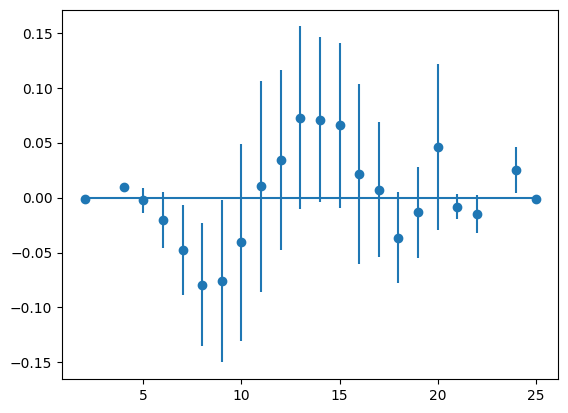

In [30]:
plt.errorbar(x_means, resids, y_sems, fmt="o", label="data")
plt.hlines(0, min(x_means), max(x_means))

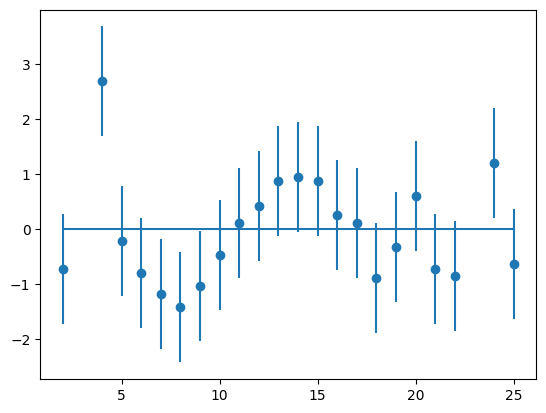

In [31]:
plt.errorbar(x_means, norm_resids, np.ones(len(x_means)), fmt="o", label="data")
plt.hlines(0, min(x_means), max(x_means))